<a href="https://colab.research.google.com/github/subod4/Simulation-and-Modeling-Projects/blob/main/Hospital_ER_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

Patient 1 arrived at 12.24 minutes.
Patient 1 is being checked in by a nurse at 12.24 minutes.
Patient 2 arrived at 12.54 minutes.
Patient 2 is being checked in by a nurse at 12.54 minutes.
Patient 3 arrived at 14.35 minutes.
Patient 2 treated in 11.77 minutes (Severity: Low)
Patient 2 is being treated by a doctor at 24.31 minutes.
Patient 3 is being checked in by a nurse at 24.31 minutes.
Patient 3 treated in 5.32 minutes (Severity: Low)
Patient 3 is being treated by a doctor at 29.63 minutes.
Patient 1 treated in 18.67 minutes (Severity: Medium)
Patient 1 is being treated by a doctor at 30.91 minutes.
Patient 2 treated in 10.90 minutes (Severity: Low)
Patient 2 finished at 35.22 minutes. Wait time: 22.67 minutes.
Patient 3 treated in 5.94 minutes (Severity: Low)
Patient 3 finished at 35.57 minutes. Wait time: 21.22 minutes.
Patient 4 arrived at 41.08 minutes.
Patient 4 is being checked in by a nurse at 41.08 minutes.
Patient 1 treated in 18.49 minutes (Severity: Medium)
Patient 1 fin

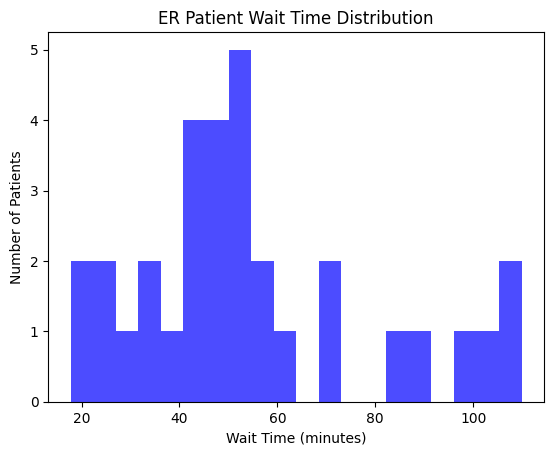

In [6]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Simulation Parameters
RANDOM_SEED = 42
NUM_DOCTORS = 3   # Number of available doctors
NUM_NURSES = 2    # Number of available nurses
ARRIVAL_RATE = 5  # Patients per hour
SIM_TIME = 8 * 60  # 8 hours (in minutes)

# Severity Levels
SEVERITY_LEVELS = {"Low": (5, 15), "Medium": (15, 30), "High": (30, 60)}

# Store wait times for analysis
wait_times = []

class HospitalER:
    def __init__(self, env, num_doctors, num_nurses):
        self.env = env
        self.doctor = simpy.Resource(env, num_doctors)
        self.nurse = simpy.Resource(env, num_nurses)

    def treat_patient(self, patient_id, severity):
        treatment_time = random.uniform(*SEVERITY_LEVELS[severity])
        yield self.env.timeout(treatment_time)
        print(f"Patient {patient_id} treated in {treatment_time:.2f} minutes (Severity: {severity})")

def patient_generator(env, er):
    patient_id = 0
    while True:
        patient_id += 1
        arrival_interval = random.expovariate(ARRIVAL_RATE / 60)  # Convert rate to minutes
        yield env.timeout(arrival_interval)
        env.process(patient_flow(env, patient_id, er))

def patient_flow(env, patient_id, er):
    arrival_time = env.now
    print(f"Patient {patient_id} arrived at {arrival_time:.2f} minutes.")

    severity = random.choice(["Low", "Medium", "High"])  # Assign severity

    # Check-in with nurse
    with er.nurse.request() as request:
        yield request
        print(f"Patient {patient_id} is being checked in by a nurse at {env.now:.2f} minutes.")
        yield env.process(er.treat_patient(patient_id, severity))

    # Treatment by doctor
    with er.doctor.request() as request:
        yield request
        print(f"Patient {patient_id} is being treated by a doctor at {env.now:.2f} minutes.")
        yield env.process(er.treat_patient(patient_id, severity))

    wait_time = env.now - arrival_time
    wait_times.append(wait_time)
    print(f"Patient {patient_id} finished at {env.now:.2f} minutes. Wait time: {wait_time:.2f} minutes.")

# Run Simulation
random.seed(RANDOM_SEED)
env = simpy.Environment()
hospital = HospitalER(env, NUM_DOCTORS, NUM_NURSES)
env.process(patient_generator(env, hospital))
env.run(until=SIM_TIME)

# Plot Wait Time Distribution
plt.hist(wait_times, bins=20, color='blue', alpha=0.7)
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Number of Patients")
plt.title("ER Patient Wait Time Distribution")
plt.show()
